In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.resnet import ResNet50_Weights

from tqdm import tqdm
from datetime import datetime
import pytz

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# 1. Train Data 확인
---
## 1-1. 데이터 Meta data 확인

In [2]:
import os

In [3]:
TRAIN_FILE_NAME = "train.csv"
DATA_PATH = "../data"

file_path = os.path.join(DATA_PATH, TRAIN_FILE_NAME)
if os.path.exists(file_path):
    train_df = pd.read_csv(file_path)
else:
    print(f"There is no file: {file_path}")

In [6]:
train_df['Molecule ChEMBL ID'].min(), train_df['Molecule ChEMBL ID'].max()

('CHEMBL1232515', 'CHEMBL5290771')

- 2010년 ~ 2023년 5월 까지 데이터

In [5]:
train_df.describe()

,Standard Value,pChEMBL Value,IC50_nM,pIC50
count,1952.000000,1952.000000,1952.000000,1952.000000
mean,649.001365,7.518586,649.001365,7.518586
std,2639.946734,1.107959,2639.946734,1.107959
min,0.022000,4.260000,0.022000,4.260000
25%,4.100000,6.680000,4.100000,6.680000
50%,15.250000,7.820000,15.250000,7.820000
75%,209.197500,8.390000,209.197500,8.390000
max,55000.000000,10.660000,55000.000000,10.660000


In [6]:
train_df.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  1952 non-null   object 
 1   Standard Type       1952 non-null   object 
 2   Standard Relation   1952 non-null   object 
 3   Standard Value      1952 non-null   float64
 4   Standard Units      1952 non-null   object 
 5   pChEMBL Value       1952 non-null   float64
 6   Assay ChEMBL ID     1952 non-null   object 
 7   Target ChEMBL ID    1952 non-null   object 
 8   Target Name         1952 non-null   object 
 9   Target Organism     1952 non-null   object 
 10  Target Type         1952 non-null   object 
 11  Document ChEMBL ID  1952 non-null   object 
 12  IC50_nM             1952 non-null   float64
 13  pIC50               1952 non-null   float64
 14  Smiles              1952 non-null   object 
dtypes: float64(4), object(11)
memory usage: 228.9+ KB


In [8]:
sum(train_df['Standard Value'] != train_df['IC50_nM'])

0

In [9]:
sum(train_df['pChEMBL Value'] != train_df['pIC50'])

0

In [10]:
# 전처리
train_df = train_df.drop(['Standard Value', 'pChEMBL Value'], axis=1)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  1952 non-null   object 
 1   Standard Type       1952 non-null   object 
 2   Standard Relation   1952 non-null   object 
 3   Standard Units      1952 non-null   object 
 4   Assay ChEMBL ID     1952 non-null   object 
 5   Target ChEMBL ID    1952 non-null   object 
 6   Target Name         1952 non-null   object 
 7   Target Organism     1952 non-null   object 
 8   Target Type         1952 non-null   object 
 9   Document ChEMBL ID  1952 non-null   object 
 10  IC50_nM             1952 non-null   float64
 11  pIC50               1952 non-null   float64
 12  Smiles              1952 non-null   object 
dtypes: float64(2), object(11)
memory usage: 198.4+ KB


In [12]:
import math

In [13]:
def to_pIC(ic50: float) -> float:
    ic50 = 9 - math.log10(ic50)
    return round(round(ic50, ndigits=3), ndigits=2)

In [14]:
sum(train_df['IC50_nM'].apply(lambda v: to_pIC(v)) != train_df['pIC50'])

0

- 학습 데이터에 존재하는 pIC 값 변환 로직 확인

In [15]:
train_df.head()

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Units,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',nM,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',nM,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',nM,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',nM,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',nM,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...


In [16]:
# 전처리
train_df = train_df.drop(train_df.columns[train_df.nunique() == 1], axis=1)

- 학습 데이터 칼럼 중 unique 값이 1개인 대상들 drop

In [17]:
sample = train_df.iloc[1:4]['Smiles']

In [18]:
sample.iloc[0]

'CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c(N3CCC(N4CCC4)CC3)cc2C1=O'

In [19]:
sample.iloc[1]

'CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c(N3CCN(C4COC4)CC3)cc2C1=O'

In [20]:
sample.iloc[2]

'CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c(N3CCN(CC(F)F)CC3)cc2C1=O'

In [21]:
sample.apply(lambda v: len(v))

1    71
2    71
3    71
Name: Smiles, dtype: int64

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  1952 non-null   object 
 1   Assay ChEMBL ID     1952 non-null   object 
 2   Document ChEMBL ID  1952 non-null   object 
 3   IC50_nM             1952 non-null   float64
 4   pIC50               1952 non-null   float64
 5   Smiles              1952 non-null   object 
dtypes: float64(2), object(4)
memory usage: 91.6+ KB


In [23]:
train_df['Molecule ChEMBL ID'].apply(lambda v: v[:6]).unique()

array(['CHEMBL'], dtype=object)

In [24]:
train_df['Assay ChEMBL ID'].apply(lambda v: v[:6]).unique()

array(['CHEMBL'], dtype=object)

In [25]:
train_df['Document ChEMBL ID'].apply(lambda v: v[:6]).unique()

array(['CHEMBL'], dtype=object)

In [26]:
# 전처리
train_df['assay'] = train_df['Assay ChEMBL ID'].apply(lambda v: v[6:])
train_df['document'] = train_df['Document ChEMBL ID'].apply(lambda v: v[6:])
train_df['molecule'] = train_df['Molecule ChEMBL ID'].apply(lambda v: v[6:])

In [27]:
train_df.head()

,Molecule ChEMBL ID,Assay ChEMBL ID,Document ChEMBL ID,IC50_nM,pIC50,Smiles,assay,document,molecule
0,CHEMBL4443947,CHEMBL4361896,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...,4361896,4359855,4443947
1,CHEMBL4556091,CHEMBL4345131,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,4345131,4342485,4556091
2,CHEMBL4566431,CHEMBL4345131,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,4345131,4342485,4566431
3,CHEMBL4545898,CHEMBL4345131,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...,4345131,4342485,4545898
4,CHEMBL4448950,CHEMBL4361896,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,4361896,4359855,4448950


- feature 중 Document, Essay 값이 같은 데이터 들의 Smiles 비교

In [39]:
# SMILES 문자열
smiles_string = 'CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c(N3CCN(C4COC4)CC3)cc2C1=O'

# 분자 객체 생성
molecule = Chem.MolFromSmiles(smiles_string)

# 2D 구조 그리기
image = Draw.MolToImage(molecule)


In [46]:
def img_of(smiles: str):
    return Draw.MolToImage(Chem.MolFromSmiles(smiles))

In [53]:
print(img_of(smiles_string))

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300 at 0x15C77EC50>


In [54]:
# 전처리
train_df['img'] = train_df['Smiles'].apply(lambda x: img_of(x))

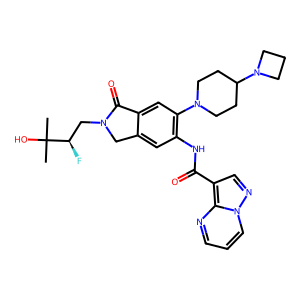

In [65]:
train_df.iloc[1:4]['img'][1]

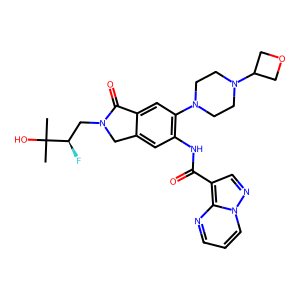

In [62]:
train_df.iloc[1:4]['img'][2]

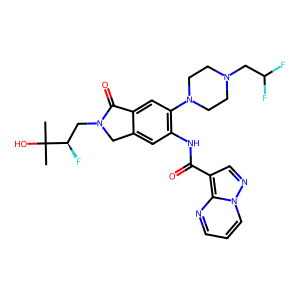

In [66]:
train_df.iloc[1:4]['img'][3]

아이디어
- smiles를 image로 변환해 해당 이미지의 임베딩을 입력으로 사용 가능

In [229]:
train_df[['assay', 'document', 'molecule']].nunique()

assay         72
document      66
molecule    1952
dtype: int64

- CHEMBL 이라는 데이터베이스를 기반으로 한 데이터셋 구성으로 보임
- document 에 여러종류의 assay 가 존재하는 듯?
  - 2024.09.03 14:43 까지 확인한 바론, document는 논문 혹은 발표 단위. assay는 실험 단위. molucule은 화합물 단위.
  - 하나의 document에 여러개의 assay가 포함될 수 있고, 각 assay는 보통 하나의 molecule을 실험하는 듯
- 위 가정이 맞다면 아래와 같은 추론이 가능해보임
  - document 별로 group by 한 document 들의 IC50 평가 값들은 유사한 범위 내에 포함될 확률이 높다 -> 확실하지 않다. document 별 통계값을 확인해볼 수 있을 것 같음.

- assay 와 document가 전체 값에 비해 종류가 적음
- 각 그룹별로 유사한 패턴을 갖지 않는지 확인
- 분자구조들의 유사도를 측정할 수 있으면 좋을 것 같음
- 각 기준으로 그룹화 한 뒤 그룹내의 각 pair들간의 유사도 평균을 산출해 해당 값이 높으면 해당 기준이 분자구조간의 유사도와 연관이 있다는 의미 이므로, 분류 기준값으로 사용해도 될 것 같음
  - https://medium.com/standigm/rdkit%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-chembl-%EB%B6%84%EC%9E%90%EB%93%A4-%EC%82%AC%EC%9D%B4%EC%9D%98-%EC%9C%A0%EC%82%AC%EB%8F%84-%EA%B2%80%EC%83%89-60307ccdb441
- 학습 데이터는 아래 링크 데이터의 메타 정보를 따름: https://www.ebi.ac.uk/chembl/web_components/explore/activities/STATE_ID:RIRpPJ6zOpLv-SJ8HzgSFw%3D%3D

In [272]:
train_df[['document', 'IC50_nM']].groupby(['document']).agg(['sum', 'mean', 'min', 'max', 'std'])

IC50_nM                                          
               sum         mean    min      max          std
document                                                    
1143094    57800.0  2890.000000  160.0   8900.0  2734.113924
1145577    23360.0   543.255814    1.0   8100.0  1324.091712
1147720   230600.0  6782.352941  150.0  30000.0  9212.186283
1150395     7179.0  1196.500000  200.0   3000.0  1092.917151
1240341      574.0   574.000000  574.0    574.0          NaN
...            ...          ...    ...      ...          ...
5149965        1.3     1.300000    1.3      1.3          NaN
5149977        0.8     0.800000    0.8      0.8          NaN
5244269     2391.0    70.323529    0.6    730.0   164.013156
5257151      922.0    41.909091   13.0    150.0    36.808267
5260813        9.7     1.940000    0.7      3.0     1.080740

[66 rows x 5 columns]

In [262]:
train_df[['assay', 'document', 'IC50_nM']].groupby(['document', 'assay']).agg(lambda x: np.mean(x))

,,IC50_nM
document,assay,
1143094,936449,2890.000000
1145577,921622,543.255814
1147720,870864,6782.352941
1150395,956501,1196.500000
1240341,1244586,574.000000
...,...,...
5149965,5150304,1.300000
5149977,5150846,0.800000
5244269,5246637,70.323529


In [258]:
train_df[['assay', 'Smiles']].groupby('assay').agg(lambda x: list(x)).iloc[7, 0]

['NC(=O)c1cnc(N[C@H]2CC[C@H](N)CC2)c2nc(-c3ccc(Cl)cc3)cn12']

In [260]:
train_df[['document', 'Smiles']].groupby('document').agg(lambda x: list(x)).iloc[1, 0]

['Clc1ccc2ncc(-c3cccc(NC4CCNC4)n3)n2c1',
 'Clc1ccc2ncc(-c3cccc(NC4CCNCC4)n3)n2c1',
 'c1cc(NC2CCNCC2)nc(-c2cnc3ccc(-c4cc[nH]n4)cn23)c1',
 'Clc1ccc2ncn(-c3cccc(NC4CCNCC4)n3)c2c1',
 'N#Cc1ccc2ncc(-c3cccc(NC4CCNCC4)n3)n2c1',
 'NC(=O)c1ccc2ncc(-c3cccc(NC4CCNCC4)n3)n2c1',
 'Clc1ccc2ncc(-c3cccc(NC4CNC4)n3)n2c1',
 'COc1ccc2ncc(-c3cccc(NC4CCNCC4)n3)n2c1',
 'Cn1cc(-c2ccc3ncc(-c4cccc(NC5CCNCC5)n4)n3c2)cn1',
 'COc1ccc2ncc(-c3cccc(NC4CNC4)n3)n2c1',
 'COc1ccc(-c2ccc3ncc(-c4cccc(NC5CCNCC5)n4)n3c2)cn1',
 'Clc1ccc2ncc(-c3cccc(NC4CCCNC4)n3)n2c1',
 'Cc1ccc2ncn(-c3cccc(NC4CCNCC4)n3)c2c1',
 'COc1ccc2ncn(-c3cccc(NC4CCNCC4)n3)c2c1',
 'c1cc(N[C@H]2CCCNC2)nc(-c2cnc3ccccn23)c1',
 'c1cc(NC2CCNCC2)nc(-c2cnc3ccccn23)c1',
 'c1cc(NC2CNC2)nc(-c2cnc3ccccn23)c1',
 'CN(C)C(=O)c1ccc2ncc(-c3cccc(NC4CCNCC4)n3)n2c1',
 'c1cc(NC2CCNCC2)nc(-c2cnc3ccc(-c4ccc[nH]4)cn23)c1',
 'c1cc(NC2CCNCC2)nc(-n2cnc3ccccc32)c1',
 'N#Cc1ccc2ncc(-c3cccc(N[C@@H]4CCCNC4)n3)n2c1',
 'Clc1ccc2c(c1)ncn2-c1cccc(NC2CCNCC2)n1',
 'c1cc(-c2cnc3ccccn23)nc(N2

## 1-2. chEMBL 데이터베이스 확인
- train set 에 포함된 document id, assay id 값을 학습에 사용하기 위해선 TEST 데이터에 대해서도 동일한 데이터를 얻을 수 있어야 함.
  - train 데이터의 Smiles 로 chEMBL 데이터에서 document 와 assay 값을 가져온 뒤 비교 검증
  - 동일한 데이터가 존재한다면 test 데이터에 대해 동일로직 검증
  - 결측치에 대한 처리 로직 고민 필요

### chEMBL schema
- full schema: https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_34_schema.png
- 주요 테이블
  - DOCS: document 정보
  - ASSAYS: assay 정보
  - ASSAY_PARAMETERS: assay 별 측정값 정보 (IC50 값)
  - TISSUE_DICTIONARY: assay에 매핑되는 화합물의 CHEMBL ID 정보

- 데이터베이스는 파일기반 처리가 가능한 sqlite로 처리

In [274]:
!wget https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_34_sqlite.tar.gz

--2024-09-03 15:35:02--  https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_34_sqlite.tar.gz
ftp.ebi.ac.uk (ftp.ebi.ac.uk) 해석 중... 193.62.193.165
다음으로 연결 중: ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 4859330198 (4.5G) [application/x-gzip]
저장 위치: `chembl_34_sqlite.tar.gz'

chembl_34_sqlite.ta   0%[                    ]   2.81M   231KB/s    약 8h 21m   ^C


In [ ]:
!tar -zxvf chembl_34_mysql.tar.gz

---
# 2. 학습 파이프라인 생성

In [222]:
class DataPreprocess:
    def __init__(self, 
                 data_dir: str, 
                 train_name: str = 'train.csv',
                 test_name: str = 'test.csv'):
        self.data_dir = data_dir
        self.train_name = train_name
        self.test_name = test_name
        self._load_datas()
        self._preprocess()
    
    def _load_datas(self):
        print("[Preprocess] start loading datas...")
        self.train_df = pd.read_csv(os.path.join(self.data_dir, self.train_name))
        self.test_df = pd.read_csv(os.path.join(self.data_dir, self.test_name))
        print("[Preprocess] end loading datas...")

    def _preprocess(self):
        def img_of(smiles: str):
            return Draw.MolToImage(Chem.MolFromSmiles(smiles))
        
        print("[Preprocess] end loading datas...")
        self.train_df['assay'] = self.train_df['Assay ChEMBL ID'].apply(lambda v: v[6:])
        self.train_df['document'] = self.train_df['Document ChEMBL ID'].apply(lambda v: v[6:])
        self.train_df['molecule'] = self.train_df['Molecule ChEMBL ID'].apply(lambda v: v[6:])
        self.train_df = self.train_df.drop(self.train_df.columns[self.train_df.nunique() == 1], axis=1)
        self.train_df['img'] = self.train_df['Smiles'].apply(lambda x: img_of(x))
        self.train_df = self.train_df.drop(['Standard Value', 'pChEMBL Value', 'Assay ChEMBL ID', 'Document ChEMBL ID', 'Molecule ChEMBL ID'], axis=1)
        
        print("[Preprocess] start test datas...")
        self.test_df['img'] = self.test_df['Smiles'].apply(lambda x: img_of(x))
        print("[Preprocess] end loading datas...")

class IC50Dataset(Dataset):
    def __init__(self, data: pd.DataFrame, transform, train: bool = True):
        self.data = data
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data.iloc[index]
        return {
            'X': self.transform(item['img']).view(-1,),
            # 'X': np.array(item['img'], dtype=np.float32).reshape(-1,),
            'Y': item['IC50_nM']
        } if self.train else {
            'X': self.transform(item['img']).view(-1,),
        }

preprocessor = DataPreprocess('../data')

train_df, test_df = preprocessor.train_df, preprocessor.test_df

# 이미지 변환 정의 (300x300 크기로 조정)
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = IC50Dataset(train_df, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32)

test_dataset = IC50Dataset(test_df, transform=transform, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# ResNet50 사전 훈련된 모델 로드 및 수정
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# embedding_size = resnet.fc.in_features  # 수정된 부분
embedding_size = 300 * 300 * 3  # 수정된 부분
resnet.fc = nn.Identity()  # 마지막 fc 레이어 제거하여 임베딩을 출력하도록 설정

# 추가 모델 정의 (임베딩을 입력으로 사용하여 회귀 작업 수행)
class SimpleImageRegressor(nn.Module):
    def __init__(self, embedding_size):
        super(SimpleImageRegressor, self).__init__()
        self.fc = nn.Linear(embedding_size, 1)  # 간단한 회귀 모델

    def forward(self, x):
        return self.fc(x)

# 모델 초기화
model = SimpleImageRegressor(embedding_size)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 훈련 루프
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    for data in tqdm(train_dataloader):
        optimizer.zero_grad()
        images, targets = data['X'], data['Y']
        outputs = model(images)
        loss = criterion(outputs.squeeze(), targets.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")

# 훈련이 완료되면 임베딩 추출 및 추가적인 예측 작업에 사용할 수 있습니다.
submission = []
for data in tqdm(test_dataloader):
    model.eval()
    images = data['X']
    outputs = model(images)
    submission.extend(outputs.detach().numpy())

sample_df = pd.read_csv('../data/sample_submission.csv')
sample_df['IC50_nM'] = np.array(submission).reshape(-1)

output_name = datetime.now(pytz.timezone("Asia/Seoul"))
sample_df.to_csv(f'../data/submissions/{output_name}.csv', index=False)

[Preprocess] start loading datas...
[Preprocess] end loading datas...
[Preprocess] end loading datas...
[Preprocess] start test datas...
[Preprocess] end loading datas...


100%|██████████| 61/61 [00:03<00:00, 17.91it/s]


Epoch [1/1], Loss: 271583311.1460


100%|██████████| 4/4 [00:00<00:00, 19.52it/s]


In [207]:
submission = []
for data in tqdm(test_dataloader):
    model.eval()
    images = data['X']
    outputs = model(images)
    submission.extend(outputs.detach().numpy())

sample_df['IC50_nM'] = np.array(submission).reshape(-1)

100%|██████████| 4/4 [00:00<00:00, 27.73it/s]


In [213]:
sample_df['IC50_nM'] = np.array(submission).reshape(-1)

In [214]:
sample_df.head()

,ID,IC50_nM,test
0,TEST_000,1633.167480,1633.167480
1,TEST_001,2095.527588,2095.527588
2,TEST_002,1781.367676,1781.367676
3,TEST_003,1138.500732,1138.500732
4,TEST_004,1984.530273,1984.530273
